# Logistic Regression

## Vectorization

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

training_data_raw = pd.read_csv('../datasets/00_output_datasets/dataset_combined.csv')
training_data_preprocessed = pd.read_csv('../datasets/01_preprocessed_datasets/dataset_preprocessed_stopwords.csv')

training_data_raw.head()


,label,text
0,hate,I hate women.
1,hate,I hate trans people.
2,hate,I hate gay people.
3,hate,I hate black people.
4,hate,I hate disabled people.


In [3]:
chosen_dataset = training_data_preprocessed

In [4]:
X_train, X_test, y_train, y_test = train_test_split(chosen_dataset['text'], 
                                                    chosen_dataset['label'], 
                                                    test_size=0.3, 
                                                    random_state=42)

# Applying TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Applying TF-IDF Vectorization with bigrams
tfidf_vectorizer_ngrams = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf_ngrams = tfidf_vectorizer_ngrams.fit_transform(X_train)
X_test_tfidf_ngrams = tfidf_vectorizer_ngrams.transform(X_test)

In [5]:
glove_dimensions = 300
glove_billion_tokens = 840

def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.rsplit(' ', glove_dimensions)
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

glove_path = f'../datasets/embeddings/glove/glove.{glove_billion_tokens}B.{glove_dimensions}d.txt'
glove_embeddings = load_glove_embeddings(glove_path)


In [6]:
from gensim.models import KeyedVectors

word2vec_path = '../datasets/embeddings/word2vec/GoogleNews-vectors-negative300.bin'

# Load pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [7]:
def vectorize_text(text, embeddings, dimensions):
    words = text.split()
    vectors = [embeddings[word] for word in words if word in embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros((dimensions,))

In [8]:
def tfidf_weighed_embeddings(text, model, vectorizer, dimensions):
    words = text.split()
    # Generate a dictionary of words and their TF-IDF scores
    word2tfidf = {word: vectorizer.idf_[vectorizer.vocabulary_[word]] 
                  for word in words if word in vectorizer.vocabulary_}

    # Compute the TF-IDF weighted average of word embeddings
    weighted_vectors = np.zeros(dimensions)
    total_weight = 0.0

    for word, tfidf_value in word2tfidf.items():
        if word in model:
            weighted_vectors += model[word] * tfidf_value
            total_weight += tfidf_value

    # Handle out-of-vocabulary cases
    if total_weight > 0:
        weighted_vectors /= total_weight
    else:
        weighted_vectors = np.zeros(dimensions)

    return weighted_vectors


In [9]:
X_train_glove = np.array([vectorize_text(text, glove_embeddings, glove_dimensions) for text in X_train])
X_test_glove = np.array([vectorize_text(text, glove_embeddings, glove_dimensions) for text in X_test])

X_train_word2vec = np.array([vectorize_text(text, word2vec_model, word2vec_model.vector_size) for text in X_train])
X_test_word2vec = np.array([vectorize_text(text, word2vec_model, word2vec_model.vector_size) for text in X_test])

X_train_tfidf_glove = np.array([tfidf_weighed_embeddings(text, glove_embeddings, tfidf_vectorizer, glove_dimensions) for text in X_train])
X_test_tfidf_glove = np.array([tfidf_weighed_embeddings(text, glove_embeddings, tfidf_vectorizer, glove_dimensions) for text in X_test])

X_train_tfidf_word2vec = np.array([tfidf_weighed_embeddings(text, word2vec_model, tfidf_vectorizer, word2vec_model.vector_size) for text in X_train])
X_test_tfidf_word2vec = np.array([tfidf_weighed_embeddings(text, word2vec_model, tfidf_vectorizer, word2vec_model.vector_size) for text in X_test])

## Evaluation

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

def benchmark_models_vectorizations(vectorized_data_sets, y_train, y_test, use_grid_search=False, c_values=None):
    """
    Train and evaluate Logistic Regression on multiple vectorized data sets.
    Optionally performs GridSearch to find the best 'C' parameter.

    Args:
    - vectorized_data_sets (list of tuples): A list where each tuple contains vectorized training and testing data (X_train_vec, X_test_vec) along with a descriptor string.
    - y_train (array-like): Training labels.
    - y_test (array-like): Testing labels.
    - use_grid_search (bool): Whether to use GridSearchCV to find the optimal 'C' parameter.
    - c_values (list): List of 'C' values to try if GridSearch is enabled.

    Returns:
    - results (dict): A dictionary containing accuracy and classification report for each vectorization approach.
    """
    results = {}
    
    if use_grid_search and c_values is None:
        c_values = [0.001, 0.01, 0.1, 1, 10, 100]  # Default C values if none provided

    for vec_name, (X_train_vec, X_test_vec) in vectorized_data_sets:
        if use_grid_search:
            # Define the model and parameter grid
            model = LogisticRegression(max_iter=1000)
            param_grid = {'C': c_values}
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
            grid_search.fit(X_train_vec, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test_vec)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            best_c = grid_search.best_params_['C']
            results[vec_name] = {'Accuracy': accuracy, 'Classification_Report': report, 'Best_C': best_c, 'y_pred': y_pred}
        else:
            # Train the model without GridSearch
            model = LogisticRegression(max_iter=1000)
            model.fit(X_train_vec, y_train)
            y_pred = model.predict(X_test_vec)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            results[vec_name] = {'Accuracy': accuracy, 'Classification_Report': report, 'y_pred': y_pred}

    return results


In [25]:
vectorized_data_sets = [
    ('TF-IDF', (X_train_tfidf, X_test_tfidf)),
    ('TF-IDF with N-Grams', (X_train_tfidf_ngrams, X_test_tfidf_ngrams)),
    ('GloVe', (X_train_glove, X_test_glove)),
    ('Word2Vec', (X_train_word2vec, X_test_word2vec)),
    ('TF-IDF weighted GloVe', (X_train_tfidf_glove, X_test_tfidf_glove)),
    ('TF-IDF weighted Word2Vec', (X_train_tfidf_word2vec, X_test_tfidf_word2vec)),
]

results = benchmark_models_vectorizations(vectorized_data_sets, y_train, y_test, use_grid_search=True)

In [27]:
for setup, result in results.items():
    print(f"{setup}:")
    print(f"Accuracy: {result['Accuracy']}")
    for label, scores in result['Classification_Report'].items():
        if isinstance(scores, dict):
            print(f"  {label} - Precision: {scores['precision']:.2f}, Recall: {scores['recall']:.2f}, F1-Score: {scores['f1-score']:.2f}")
    if 'Best_C' in result:
        print(f"  Best C: {result['Best_C']}")
    print()


TF-IDF:
Accuracy: 0.6861448780834577
  hate - Precision: 0.70, Recall: 0.74, F1-Score: 0.72
  not_hate - Precision: 0.66, Recall: 0.62, F1-Score: 0.64
  macro avg - Precision: 0.68, Recall: 0.68, F1-Score: 0.68
  weighted avg - Precision: 0.68, Recall: 0.69, F1-Score: 0.68
  Best C: 1

TF-IDF with N-Grams:
Accuracy: 0.6409326793203952
  hate - Precision: 0.66, Recall: 0.72, F1-Score: 0.69
  not_hate - Precision: 0.61, Recall: 0.54, F1-Score: 0.57
  macro avg - Precision: 0.64, Recall: 0.63, F1-Score: 0.63
  weighted avg - Precision: 0.64, Recall: 0.64, F1-Score: 0.64
  Best C: 1

GloVe:
Accuracy: 0.6675908153835217
  hate - Precision: 0.69, Recall: 0.73, F1-Score: 0.71
  not_hate - Precision: 0.64, Recall: 0.59, F1-Score: 0.61
  macro avg - Precision: 0.66, Recall: 0.66, F1-Score: 0.66
  weighted avg - Precision: 0.67, Recall: 0.67, F1-Score: 0.67
  Best C: 100

Word2Vec:
Accuracy: 0.6615483045425464
  hate - Precision: 0.67, Recall: 0.75, F1-Score: 0.71
  not_hate - Precision: 0.64, R

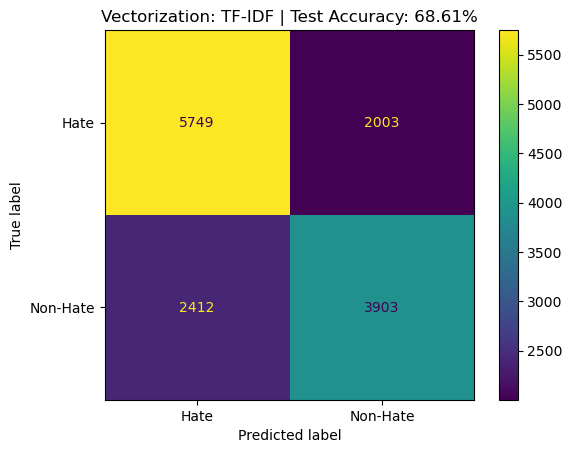

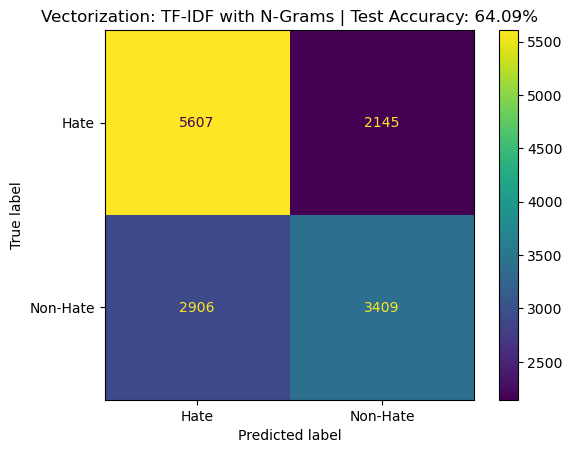

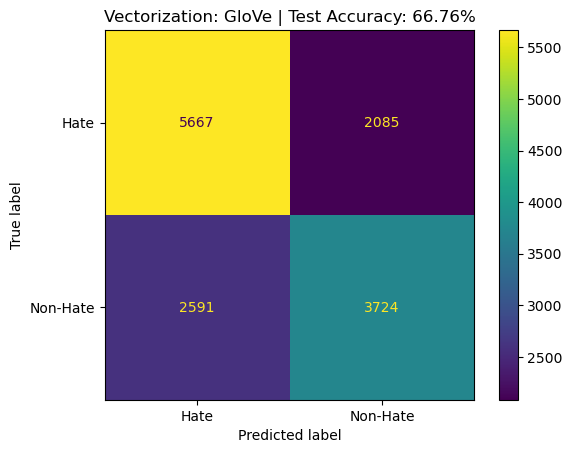

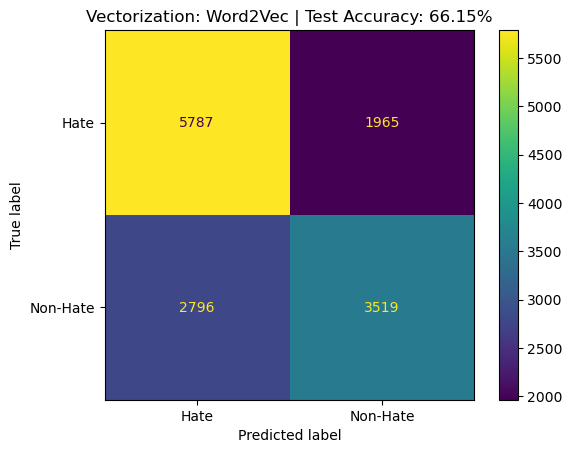

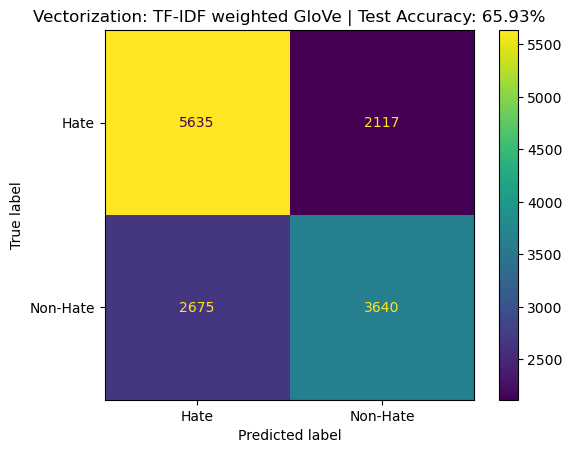

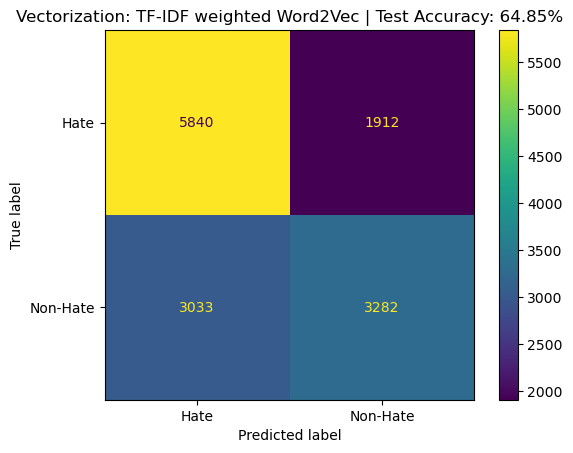

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

for name in results:
    result = results[name]
    y_pred = result['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate', 'Non-Hate'])
    disp.plot()
    disp.ax_.set_title(f'Vectorization: {name} | Test Accuracy: {result["Accuracy"]*100:.2f}% | C: {result.get("Best_C", "N/A")}')